# Logistic Regression

This notebook will demonstrate an application of Logistic Regression on the [IBMEmployeeAttrition](https://github.com/Madison-Bunting/INDE-577/blob/main/IBMEmployeeAttrition.csv) dataset, first without [principle component analysis](https://github.com/Madison-Bunting/INDE-577/tree/main/unsupervised%20learning/2%20-%20principle%20component%20analysis), then adding it in for comparison.

In [2]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV
import time

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice result formatting
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA

#importing the dataset as a dataframe
df = pd.read_csv("https://raw.githubusercontent.com/Madison-Bunting/INDE-577/main/IBMEmployeeAttrition.csv")

## Pre-Processing
Before we can run logistic regression, we need to pre-process the data and encode labels. We will do this using sklearn's preprocessing package.

First, we remove variables with zero variance (as uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook.

In [3]:
#Drop variables with zero variance: EmployeeCount, Over18, and StandardHours
df.drop('EmployeeCount', axis = 1, inplace = True)
df.drop('Over18', axis = 1, inplace = True)
df.drop('StandardHours', axis = 1, inplace = True)

#Replacing Yes/No in the target variable (Attrition) with 1/0
df['Attrition'] = df['Attrition'].map({'No':0, 'Yes':1})

Correlated variables will impact logistic regression outputs, so those should be dropped as well. As uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook, we should drop Job Level, Total Working Years, Years in Current Role, Years with Current Manager, and Percent Salary Hike.

In [4]:
#Dropping variables listed above that are correlated
df_final = df.drop(['JobLevel','TotalWorkingYears','YearsInCurrentRole', 'YearsWithCurrManager' , 'PercentSalaryHike'], axis=1)
#Confirm those variables were sucessfully dropped
df_final

,Index,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,...,MonthlyRate,NumCompaniesWorked,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion
0,1,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,...,19479,8,Yes,3,1,0,0,1,6,0
1,2,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,...,24907,1,No,4,4,1,3,3,10,1
2,3,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,...,2396,6,Yes,3,2,0,3,3,0,0
3,4,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,...,23159,1,Yes,3,3,0,3,3,8,3
4,5,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,7,...,16632,9,No,3,4,1,3,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1466,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,2061,...,12290,4,No,3,3,1,3,3,5,0
1466,1467,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,2062,...,21457,4,No,3,1,1,5,3,7,1
1467,1468,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,...,5174,1,Yes,4,2,1,0,3,6,0
1468,1469,49,0,Travel_Frequently,1023,Sales,2,3,Medical,2065,...,13243,2,No,3,4,0,3,2,9,0


In [5]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['BusinessTravel'] = le.fit_transform(res_df['BusinessTravel'])
    res_df['Department'] = le.fit_transform(res_df['Department'])
    res_df['Education'] = le.fit_transform(res_df['Education'])
    res_df['EducationField'] = le.fit_transform(res_df['EducationField'])
    res_df['JobRole'] = le.fit_transform(res_df['JobRole'])
    res_df['Gender'] = le.fit_transform(res_df['Gender'])
    res_df['MaritalStatus'] = le.fit_transform(res_df['MaritalStatus'])
    res_df['OverTime'] = le.fit_transform(res_df['OverTime'])
    res_df['Attrition'] = le.fit_transform(res_df['Attrition'])
    return res_df

#Run the function on the desired dataset
encoded_df = preprocessor(df_final)

The next step is to select which features we want to use with logistic regression and standardize them.

In [6]:
#Selecting features
X = encoded_df.drop(['Attrition'],axis =1)
y = encoded_df['Attrition']
y

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64

In [7]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


## Split into Train and Test data
To apply logistic regression, the data must be split into "training" and "test" data.

In [8]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [10]:
start = time.time()

#Instantiate the model
logreg = LogisticRegression()
#Fit the model with data
logreg.fit(X_train,y_train)

end = time.time()
logreg_time = end - start
print('Train Time (seconds) of Logistic Regression without PCA:',logreg_time)

y_pred_logreg = logreg.predict(X_test)

Train Time (seconds) of Logistic Regression without PCA: 0.030419588088989258


# Performance Analysis
The next step is to conduct a performance analysis of the model. We do this by examining the confusion matrix and the Receiver Operating Characteristic (ROC) curve.

In [129]:
print("Accuracy:", accuracy_score(y_test,y_pred_logreg))

Accuracy: 0.8994565217391305


Text(0.5, 257.44, 'Predicted label')

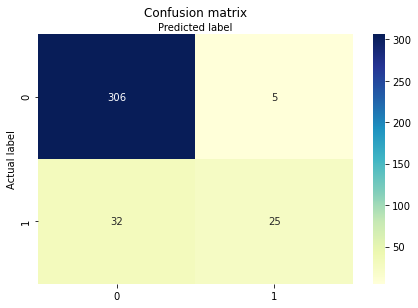

In [130]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [131]:
#Print a nicely formatted report
classify_logreg = classification_report(y_test, y_pred_logreg)
print("\nClassification Report")
print(classify_logreg)


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       311
           1       0.83      0.44      0.57        57

    accuracy                           0.90       368
   macro avg       0.87      0.71      0.76       368
weighted avg       0.89      0.90      0.89       368



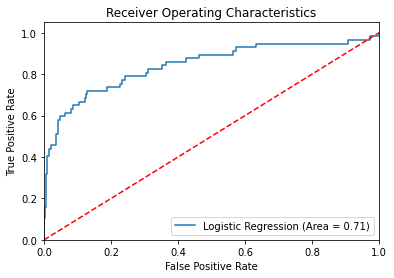

In [132]:
#Plot the ROC curve
logreg_roc_auc = roc_auc_score(y_test,y_pred_logreg)
fpr, tpr, thresholds = roc_curve(y_test,logreg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (Area = %0.2f)' % logreg_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()

# Using PCA

In [118]:
# Make an instance of the model and specify that 90% of the variance needs to be retained
n = 90
pca = PCA(n/100)

# Fit the PCA on the training set
pca.fit(X_train)

print('To retain',n,'% of the variation, we needed',pca.n_components_,'components')

To retain 90 % of the variation, we needed 21 components


In [119]:
# Applying transformation to both Training and Test set

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [120]:
# Logistic Regression with PCA

start = time.time()

logreg_pca = LogisticRegression()
logreg_pca.fit(X_train_pca,y_train)

end = time.time()
logreg_time_pca = end-start
print('Train Time (seconds) of Logistic Regression with PCA:',logreg_time_pca)

y_pred_logreg_pca = logreg_pca.predict(X_test_pca)

Train Time (seconds) of Logistic Regression with PCA: 0.015841007232666016


In [121]:
print("Accuracy:", accuracy_score(y_test,y_pred_logreg_pca))

Accuracy: 0.8831521739130435


Text(0.5, 257.44, 'Predicted label')

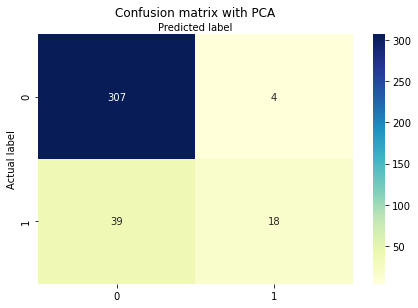

In [122]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_logreg_pca)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix with PCA', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [123]:
classify_logreg_pca = classification_report(y_test, y_pred_logreg_pca)
print("\nClassification Report with PCA")
print(classify_logreg_pca)


Classification Report with PCA
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       311
           1       0.82      0.32      0.46        57

    accuracy                           0.88       368
   macro avg       0.85      0.65      0.70       368
weighted avg       0.88      0.88      0.86       368



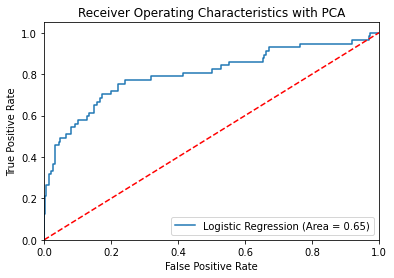

In [124]:
logreg_roc_auc_pca = roc_auc_score(y_test,y_pred_logreg_pca)
fpr, tpr, thresholds = roc_curve(y_test,logreg_pca.predict_proba(X_test_pca)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (Area = %0.2f)' % logreg_roc_auc_pca)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics with PCA')
plt.legend(loc="lower right")
plt.show()

PCA made logistic regression slightly less accurate, but it also ran slightly faster. See comparison of PCA across algorithms [here](https://github.com/Madison-Bunting/INDE-577/tree/main/unsupervised%20learning/2%20-%20principle%20component%20analysis)